# Monte Carlo Simulation

To verify asymptotic power and size of the three tests, we conduct a MC simulation.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys 
from scipy.stats import norm
from scipy.stats import kstest
import scipy.stats as stats
import seaborn as sns
sys.executable

sys.path.append('../')
from utils import utils
sys.executable

'/Users/fanghema/Desktop/aaSTAT_5200/STAT_5200_final_project/env/bin/python'

In [2]:
def simulate_dgp(N, K, R, T,
                heterogeneity_strength=0.0,
                sigma_u=0.2,
                sigma_eps=0.5,
                sigma_g=1.0,
                seed=None):
    """
    Simulates data consistent with your estimator structure.
    
    N: industries
    K: observed factors (Mkt, SMB, ...)
    R: latent factors in your iterative_convergence
    T: number of periods
    
    heterogeneity_strength = 0  → null hypothesis
    heterogeneity_strength > 0 → alternative
    """
    rng = np.random.default_rng(seed)
    
    G = rng.normal(0, sigma_g, size=(T, R))
    
    alpha = np.zeros(N)                
    lambda_true = np.zeros((N, K))
    
    for i in range(N):
        lambda_true[i] = heterogeneity_strength * rng.normal(0, 1, size=K)
    
    beta_star_true = rng.normal(0, 1, size=(N, R))
    
    beta_true = np.zeros((N, K, T))
    for i in range(N):
        beta_i0 = rng.normal(0, 1, size=K)
        for t in range(T):
            beta_true[i,:,t] = beta_i0 + sigma_u * rng.normal(0,1,size=K)
    
    realized_cov = beta_true + sigma_u * rng.normal(0,1,size=(N,K,T))
    
    residuals = sigma_u * rng.normal(0,1,size=(N,K,T))
    
    r = np.zeros((N,T))
    for i in range(N):
        for t in range(T):
            mean_part = alpha[i] + lambda_true[i] @ beta_true[i,:,t]
            g_part    = beta_star_true[i] @ G[t]
            r[i,t] = mean_part + g_part + sigma_eps * rng.normal()
    
    return beta_true, r, realized_cov, residuals, G, beta_star_true, lambda_true

In [3]:
def run_mc(N, K, R, T, n_rep=200, verbose=False, heterogeneity_strength = 0):
    """
    Estimates empirical size of your tests:
    - full homogeneity
    - intercept homogeneity
    - slope homogeneity
    
    Simulates data under the TRUE null hypothesis (H0):
        - all lambda_i identical (here: all zeros)
        - all alpha_i identical (zeros)
    """

    gamma_a_lambda = np.empty_like(np.arange(n_rep))
    gamma_a = np.empty_like(np.arange(n_rep))
    gamma_lambda = np.empty_like(np.arange(n_rep))
    
    for rep in range(n_rep):
        if verbose and (rep % 100) == 0:
            print(f"Processing {rep} out of {n_rep}")
        beta_true, r, realized_cov, residuals, G_true, beta_star_true, _ = \
            simulate_dgp(
                N=N, K=K, R=R, T=T,
                heterogeneity_strength=heterogeneity_strength
            )

        beta_hat = beta_true  
        eta_hat, G_hat, beta_star_hat, _ = utils.iterative_convergence(
            beta_hat, r, N, K, R, T, n_iter=500
        )
        avar = utils.estimate_avar(
            beta_hat=beta_hat,
            excess_returns=r,
            eta=eta_hat,
            G=G_hat,
            beta_star=beta_star_hat,
            realized_covariance=realized_cov,
            residuals=residuals,
            N=N, K=K, R=R, T=T,
        )
        
        full = utils.full_homogeneity_test(eta_hat, avar, N, K, T)
        inta = utils.intercept_homogeneity_test(eta_hat, avar, N, K, T)
        slope = utils.slope_homogeneity_test(eta_hat, avar, N, K, T)

        gamma_a_lambda[rep] = full
        gamma_a[rep] = inta
        gamma_lambda[rep] = slope

    return {
        "gamma_a_lambda": gamma_a_lambda,
        "gamma_a": gamma_a,
        "gamma_lambda": gamma_lambda,
    }


In [4]:
alpha = 0.05
n_rep = 1000
print("SIZE TEST RESULTS:")

results = run_mc(N=20, K=3, R=1, T=200, n_rep=n_rep, verbose= True)

SIZE TEST RESULTS:
Processing 0 out of 1000
Processing 100 out of 1000
Processing 200 out of 1000
Processing 300 out of 1000
Processing 400 out of 1000
Processing 500 out of 1000
Processing 600 out of 1000
Processing 700 out of 1000
Processing 800 out of 1000
Processing 900 out of 1000


In [5]:
critical = norm.ppf(1 - alpha/2)
print(f"Type I error rate - joint: ")
print(f"{(np.abs(results['gamma_a_lambda']) > critical).sum() / n_rep:.4f}")

print(f"Type I error rate - intercept: ")
print(f"{(np.abs(results['gamma_a']) > critical).sum() / n_rep:.4f}")

print(f"Type I error rate - slope: ")
print(f"{(np.abs(results['gamma_lambda']) > critical).sum() / n_rep:.4f}")

Type I error rate - joint: 
0.9960
Type I error rate - intercept: 
0.9420
Type I error rate - slope: 
0.9120


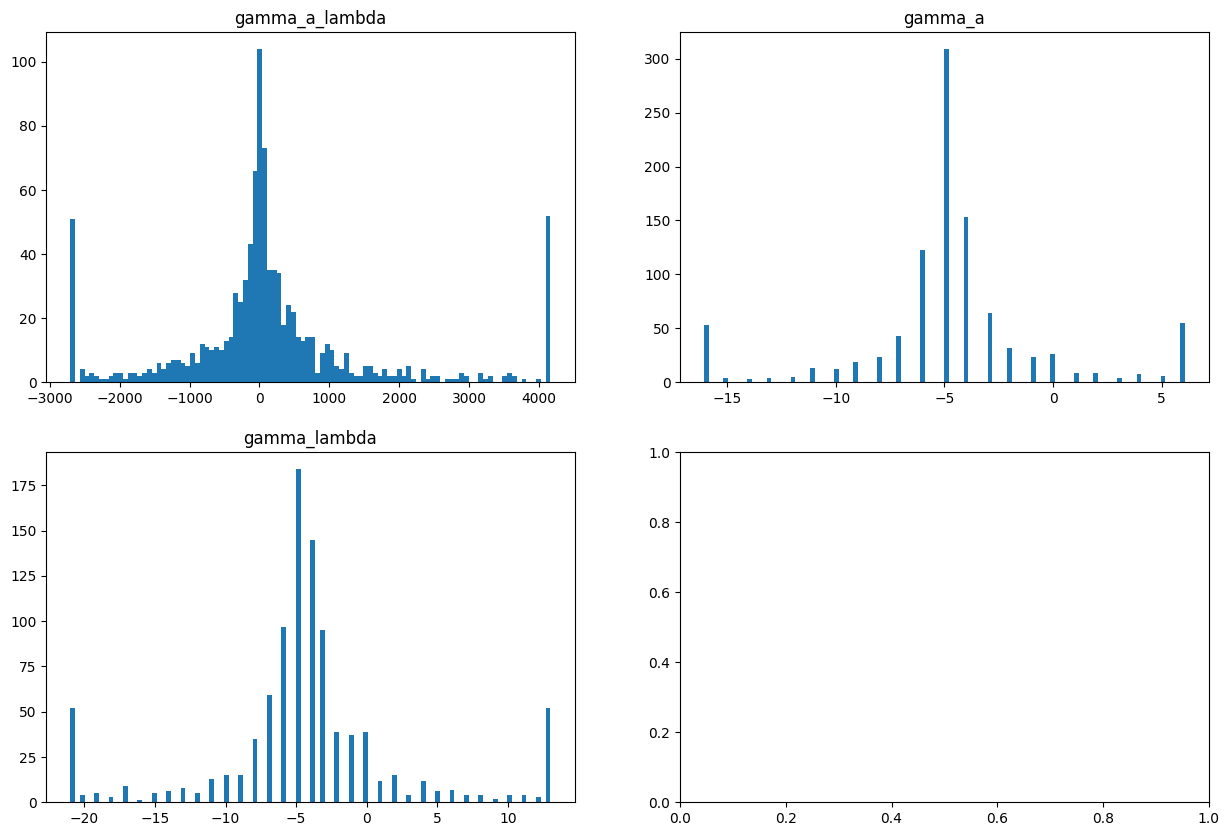

In [6]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10))
axes = np.ravel(axes)

for i, test_statistic in enumerate(['gamma_a_lambda', 'gamma_a', 'gamma_lambda']):
    axes[i].hist(
        utils.clean(results[test_statistic]),
        bins = 100,
    )
    axes[i].set_title(test_statistic)

In [7]:
power_results = {}
for delta in [0.1, 0.2, 0.5, 1.0]:

    print("===================================================================")
    print(f"POWER for heterogeneity_strength={delta}:")

    local_results = run_mc(N=20, K=3, R=1, T=200, 
                    heterogeneity_strength=delta, 
                    n_rep=500, 
                    verbose = True)
    
    power_results[delta]= local_results
    
    critical = norm.ppf(1 - alpha/2)
    print(f"Power - joint")
    print(f"{(np.abs(results['gamma_a_lambda']) > critical).sum() / n_rep:.4f}")

    print(f"Power - intercept")
    print(f"{(np.abs(results['gamma_a']) > critical).sum() / n_rep:.4f}")

    print(f"Power - slope")
    print(f"{(np.abs(results['gamma_lambda']) > critical).sum() / n_rep:.4f}")
    print("===================================================================")
        

POWER for heterogeneity_strength=0.1:
Processing 0 out of 500
Processing 100 out of 500
Processing 200 out of 500
Processing 300 out of 500
Processing 400 out of 500
Power - joint
0.9960
Power - intercept
0.9420
Power - slope
0.9120
POWER for heterogeneity_strength=0.2:
Processing 0 out of 500
Processing 100 out of 500
Processing 200 out of 500
Processing 300 out of 500
Processing 400 out of 500
Power - joint
0.9960
Power - intercept
0.9420
Power - slope
0.9120
POWER for heterogeneity_strength=0.5:
Processing 0 out of 500
Processing 100 out of 500
Processing 200 out of 500
Processing 300 out of 500
Processing 400 out of 500
Power - joint
0.9960
Power - intercept
0.9420
Power - slope
0.9120
POWER for heterogeneity_strength=1.0:
Processing 0 out of 500
Processing 100 out of 500
Processing 200 out of 500
Processing 300 out of 500
Processing 400 out of 500
Power - joint
0.9960
Power - intercept
0.9420
Power - slope
0.9120


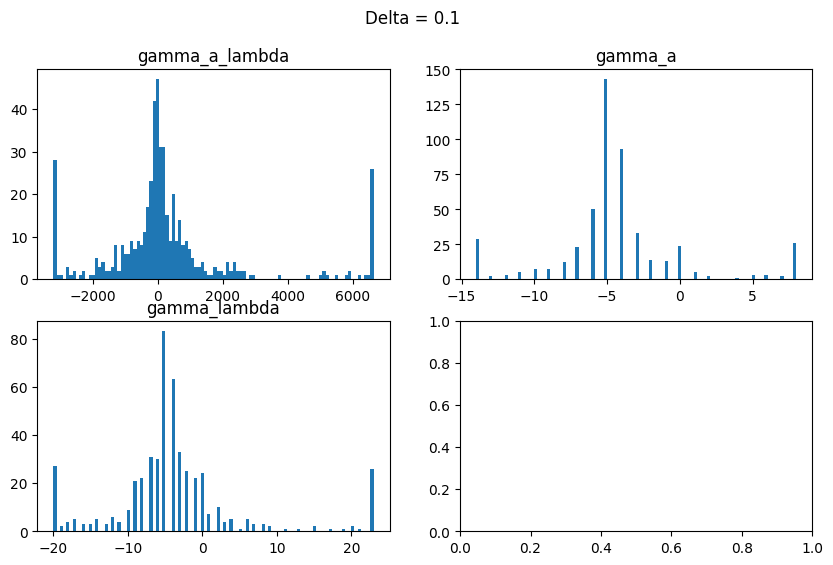

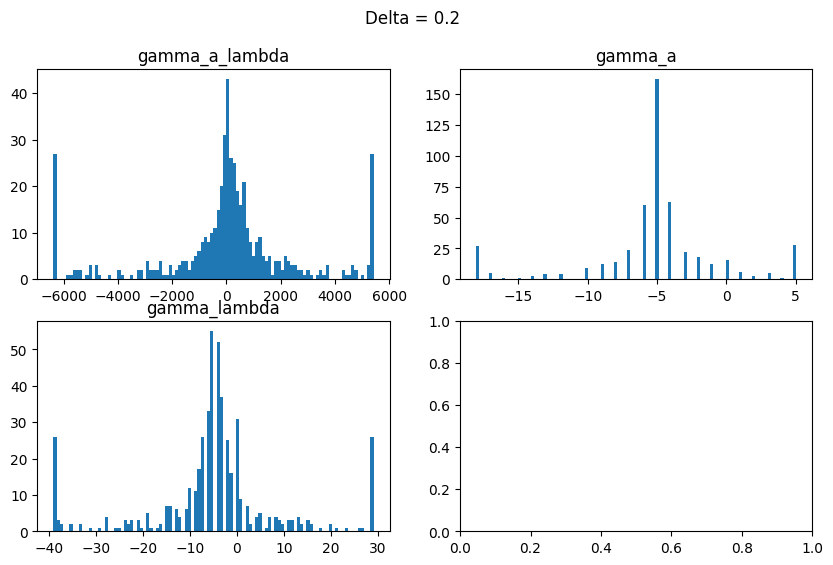

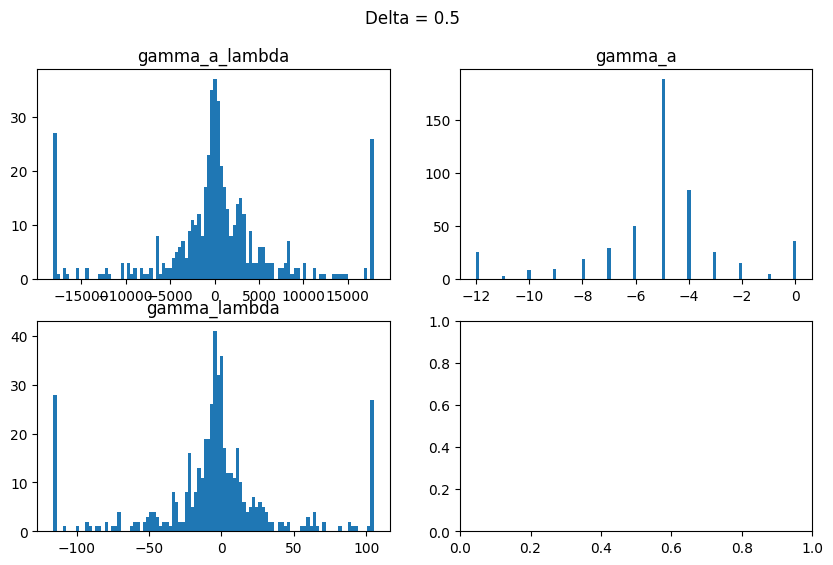

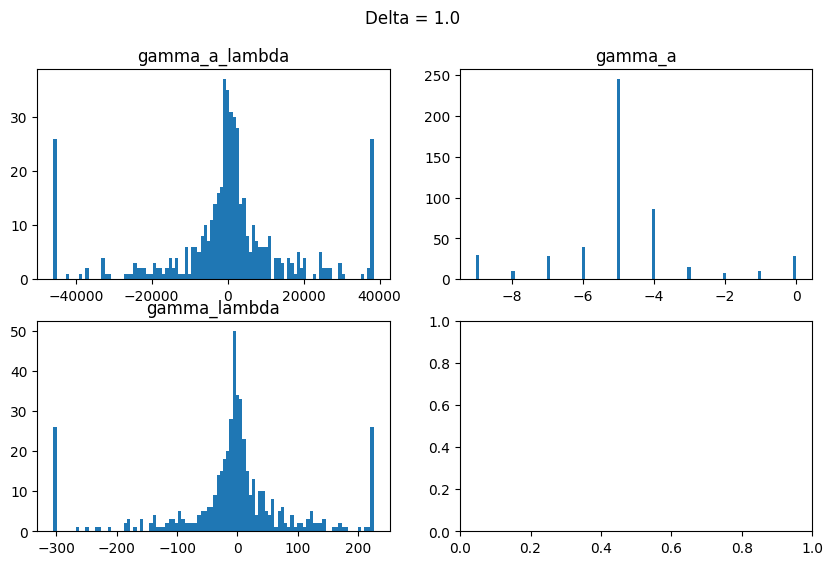

In [8]:
for delta in [0.1, 0.2, 0.5, 1.0]:
    fig, axes = plt.subplots(2, 2, figsize = (10, 6))
    axes = np.ravel(axes)

    for i, test_statistic in enumerate(['gamma_a_lambda', 'gamma_a', 'gamma_lambda']):
        axes[i].hist(
            utils.clean(power_results[delta][test_statistic]),
            bins = 100,
        )
        axes[i].set_title(test_statistic)
    fig.suptitle(f"Delta = {delta}")

We examine the distribution of the test statistic under null

In [9]:
print("MC parameters")
print("N=20")
print("K=3")
print("R=1")
print("T=200")
for k, v in results.items():
    print(f"==========" * 5)
    print(k)
    print(f"mean: {v.mean()}")
    print(f"std: {v.std()}")
    print(f"min: {v.min()}")
    print(f"max: {v.max()}")

MC parameters
N=20
K=3
R=1
T=200
gamma_a_lambda
mean: 420.043
std: 24151.585248657095
min: -507281
max: 422577
gamma_a
mean: -8.414
std: 75.15964744462285
min: -1923
max: 109
gamma_lambda
mean: -0.58
std: 168.72552148385856
min: -1709
max: 4320


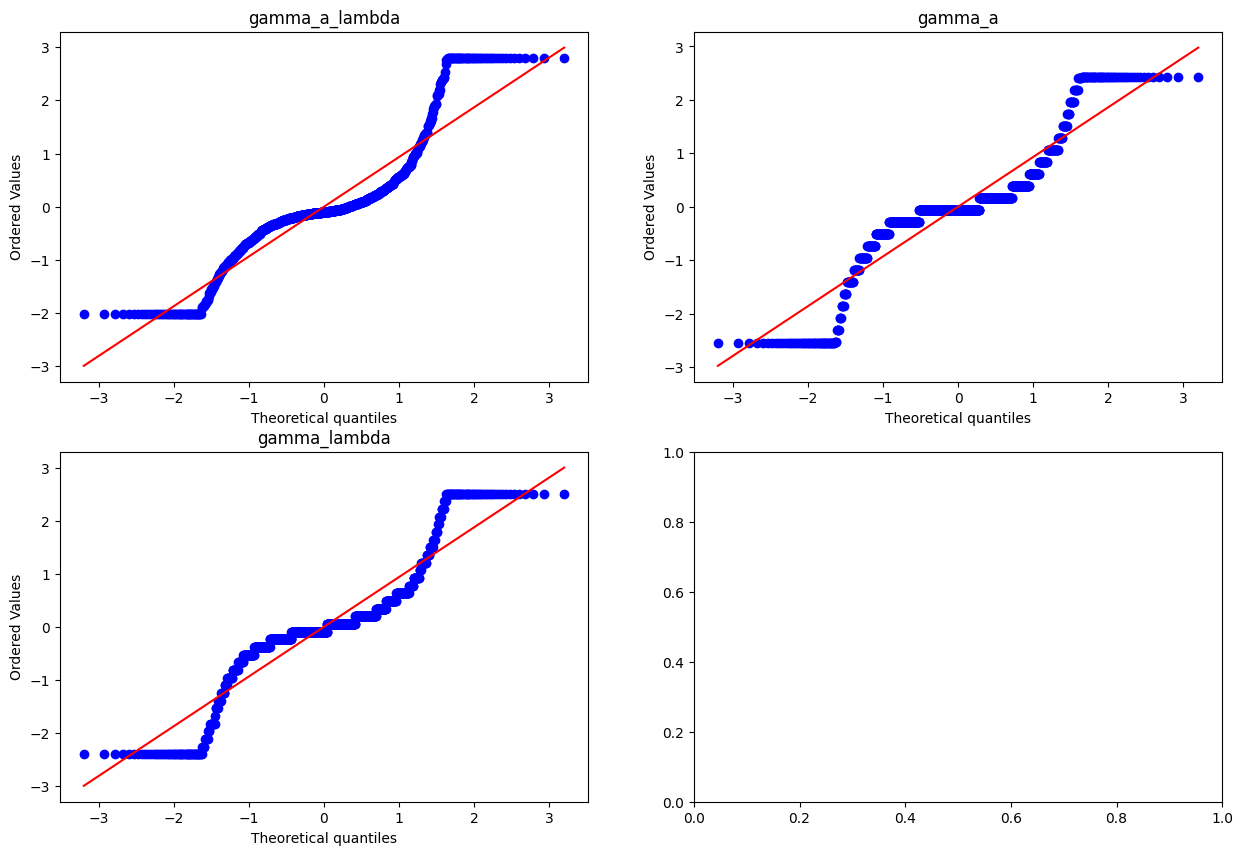

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = np.ravel(axes)

for i, test_statistic in enumerate(['gamma_a_lambda', 'gamma_a', 'gamma_lambda']):
    vals = utils.clean(results[test_statistic])
    z_vals = (vals- vals.mean()) / vals.std()
    stats.probplot(z_vals, dist="norm", plot=axes[i])
    axes[i].set_title(test_statistic)

## Asymptotic properties of estimator

In [ ]:
def run_mc_eta_properties(
    N=20, K=3, R=1, T=200,
    n_rep=200,
    heterogeneity_strength=0.5,
    sigma_u=0.2,
    sigma_eps=0.5,
    sigma_g=1.0,
    seed=0
):
    """
    Monte Carlo experiment for sampling properties of the eta estimator.
    Returns:
        eta_hats: (n_rep, N, K+1)
        avars:    (n_rep, N*(K+1), N*(K+1))
        lambda_true: (N, K)
    """

    rng = np.random.default_rng(seed)

    p = N * (K+1)

    eta_hats = np.zeros((n_rep, N, K+1))
    avars    = np.zeros((n_rep, p, p))
    lambda_store = None  # to save true lambda

    for rep in range(n_rep):
        if(rep % 10) == 0:
            print(f"Processing rep {rep}")
        rep_seed = rng.integers(1, 1_000_000_000)

        (
            beta_true,          # (N, K, T)
            r,                  # (N, T)
            realized_cov,       # (N, K, T)
            residuals,          # (N, K, T)
            G_true,             # (T, R)
            beta_star_true,     # (N, R)
            lambda_true         # (N, K)
        ) = simulate_dgp(
            N=N, K=K, R=R, T=T,
            heterogeneity_strength=heterogeneity_strength,
            sigma_u=sigma_u,
            sigma_eps=sigma_eps,
            sigma_g=sigma_g,
            seed=rep_seed
        )

        if lambda_store is None:
            lambda_store = lambda_true.copy()

        beta_hat = beta_true

        # Estimate eta
        eta_hat, G_hat, beta_star_hat, objvals = utils.iterative_convergence(
            beta_hat=beta_hat,
            excess_returns=r,
            N=N, K=K, R=R, T=T,
            n_iter=2000
        )

        # Estimate AVAR
        avar_hat = utils.estimate_avar(
            beta_hat=beta_hat,
            excess_returns=r,
            eta=eta_hat,
            G=G_hat,
            beta_star=beta_star_hat,
            realized_covariance=realized_cov,
            residuals=residuals,
            N=N, K=K, R=R, T=T
        )

        eta_hats[rep] = eta_hat
        avars[rep] = avar_hat

    return eta_hats, avars, lambda_store

def analyze_eta_bias_variance(eta_hats, lambda_true, N, K, T):
    """
    eta_hats: (n_rep, N, K+1)
    lambda_true: (N, K)
    """
    n_rep = eta_hats.shape[0]
    Kp1 = K+1
    p = N*Kp1

    # build eta_true array
    eta_true = np.zeros((N, K+1))
    eta_true[:,0] = 0.0
    eta_true[:,1:] = lambda_true

    eta_true_vec = eta_true.reshape(p)

    # empirical mean
    eta_bar = eta_hats.mean(axis=0)
    eta_bias = eta_bar - eta_true

    print("\n==== BIAS OF ETA ESTIMATOR ====")
    print("Max abs bias:", np.max(np.abs(eta_bias)))
    print("Mean abs bias:", np.mean(np.abs(eta_bias)))

    eta_vec = eta_hats.reshape(n_rep, p)
    eta_centered = eta_vec - eta_true_vec

    emp_cov = (eta_centered.T @ eta_centered) / (n_rep - 1)
    
    return eta_true, eta_true_vec, emp_cov

def compare_empirical_to_avar(emp_cov, avars, T, N, K):
    Kp1 = K + 1
    p = N*Kp1

    avar_mean = avars.mean(axis=0)
    emp_var = np.diag(emp_cov)
    theo_var = np.diag(avar_mean) / T  # theoretical scaled variance

    print("\n==== VARIANCE COMPARISON ====")
    print("Empirical variance (first 10):", emp_var[:10])
    print("Theoretical variance (first 10):", theo_var[:10])

    return emp_var, theo_var


def check_z_normality(eta_hats, avars, eta_true_vec, T, param_index):
    """
    param_index: index in vec(eta) to test (0 to p-1)
    """

    n_rep = eta_hats.shape[0]
    p = eta_true_vec.shape[0]

    z_vals = []

    for rep in range(n_rep):
        eta_vec = eta_hats[rep].reshape(p)
        avar_hat = avars[rep]

        se = np.sqrt(avar_hat[param_index, param_index] / T)
        z = (eta_vec[param_index] - eta_true_vec[param_index]) / se

        z_vals.append(z)

    z_vals = np.array(z_vals)

    print("\n==== NORMALITY CHECK ====")
    print("mean(z):", z_vals.mean())
    print("std(z):", z_vals.std())
    print("KS test vs N(0,1):", kstest(z_vals, 'norm'))

    return z_vals

In [ ]:
def coverage_probability(eta_hats, avars, eta_true_vec, param_index, T, alpha=0.05):
    zcrit = norm.ppf(1 - alpha/2)

    n_rep = eta_hats.shape[0]
    p = len(eta_true_vec)
    covered = 0

    for rep in range(n_rep):
        eta_vec = eta_hats[rep].reshape(p)
        avar_hat = avars[rep]
        se = np.sqrt(avar_hat[param_index, param_index] / T)

        ci_low  = eta_vec[param_index] - zcrit*se
        ci_high = eta_vec[param_index] + zcrit*se

        if (eta_true_vec[param_index] >= ci_low) and (eta_true_vec[param_index] <= ci_high):
            covered += 1

    coverage = covered / n_rep
    print("\n==== COVERAGE ====")
    print(f"Coverage probability: {coverage:.3f} (target = 0.95)")
    return coverage

In [ ]:
eta_hats, avars, lambda_true = run_mc_eta_properties(
    N=20, K=3, R=1, T=200,
    heterogeneity_strength=0.5,
    n_rep=500
)

eta_true, eta_true_vec, emp_cov = analyze_eta_bias_variance(
    eta_hats, lambda_true, N=20, K=3, T=200
)

emp_var, theo_var = compare_empirical_to_avar(
    emp_cov, avars, T=200, N=20, K=3
)

Kp1 = 3 + 1
param_index = 0*Kp1 + 1  # (asset 0, slope 1)

z_vals = check_z_normality(
    eta_hats, avars, eta_true_vec, T=200, param_index=param_index
)

coverage = coverage_probability(
    eta_hats, avars, eta_true_vec, param_index=param_index, T=200
)


==== BIAS OF ETA ESTIMATOR ====
Max abs bias: 1.6593719669770914
Mean abs bias: 0.3159582355355777

==== VARIANCE COMPARISON ====
Empirical variance (first 10): [0.09689915 0.50258872 0.34710584 0.27115956 0.11882595 0.58212828
 1.82794002 0.42457894 0.1129175  0.3213619 ]
Theoretical variance (first 10): [0.00713551 0.00715691 0.00715691 0.00715691 0.00714484 0.00715691
 0.00714225 0.00715691 0.00714669 0.00715691]

==== NORMALITY CHECK ====
mean(z): -5.956843693296206
std(z): 7.766782441554891
KS test vs N(0,1): KstestResult(statistic=np.float64(0.6739886744018414), pvalue=np.float64(4.9638594541501135e-225), statistic_location=np.float64(-1.7278080080687428), statistic_sign=np.int8(1))

==== COVERAGE ====
Coverage probability: 0.168 (target = 0.95)


In [ ]:
def param_labels(N, K):
    labels = []
    for i in range(N):
        labels.append(f"α_{i}")
        for k in range(K):
            labels.append(f"λ_{i,k}")
    return labels

def plot_eta_bias(eta_hats, eta_true, N, K):
    labels = param_labels(N, K)
    p = len(labels)

    eta_mean = eta_hats.mean(axis=0).reshape(-1)
    eta_true_vec = eta_true.reshape(-1)

    bias = eta_mean - eta_true_vec

    plt.figure(figsize=(14,5))
    plt.bar(range(p), bias)
    plt.axhline(0, color="black", linewidth=1)
    plt.xticks(range(p), labels, rotation=90)
    plt.title("Bias of η̂ parameters over MC replications")
    plt.tight_layout()
    plt.show()

def plot_variance_comparison(emp_cov, avars, T, N, K):
    labels = param_labels(N, K)
    p = len(labels)

    emp_var = np.diag(emp_cov)
    avar_mean = avars.mean(axis=0)
    theo_var = np.diag(avar_mean) / T

    plt.figure(figsize=(14,5))
    plt.plot(emp_var, label="Empirical Var(η̂)", marker='o')
    plt.plot(theo_var, label="Theoretical Var from AVAR/T", marker='x')
    plt.xticks(range(p), labels, rotation=90)
    plt.legend()
    plt.title("Empirical vs Theoretical Variance of η̂")
    plt.tight_layout()
    plt.show()

def plot_z_histogram(z_vals, param_label):
    plt.figure(figsize=(8,5))
    plt.hist(z_vals, bins=30, density=True, alpha=0.6, label="MC Z-values")

    x = np.linspace(-4,4,200)
    plt.plot(x, norm.pdf(x), color="red", label="N(0,1) PDF")

    plt.title(f"Z-Score Histogram for {param_label}")
    plt.legend()
    plt.show()

def plot_qq(z_vals, param_label):
    plt.figure(figsize=(6,6))
    stats.probplot(z_vals, dist="norm", plot=plt)
    plt.title(f"QQ Plot for Z-scores: {param_label}")
    plt.show()

def plot_coverage(coverage, param_label):
    plt.figure(figsize=(5,4))
    plt.bar([0], [coverage], width=0.4)
    plt.axhline(0.95, color="red", linestyle="--", label="95% target")
    plt.ylim(0,1)
    plt.xticks([0], [param_label])
    plt.ylabel("Coverage probability")
    plt.legend()
    plt.title("Empirical 95% CI Coverage")
    plt.show()

def plot_eta_heatmap(eta_hats, eta_true):
    error = eta_hats.mean(axis=0) - eta_true  # (N, K+1)
    
    plt.figure(figsize=(10,6))
    sns.heatmap(np.abs(error), cmap="magma", annot=False)
    plt.title("Mean Absolute Error Heatmap of η̂")
    plt.xlabel("Parameter (α, λ1,...,λK)")
    plt.ylabel("Industry index")
    plt.show()

def plot_eta_boxplots(eta_hats, eta_true, N, K):
    labels = param_labels(N, K)
    p = len(labels)

    plt.figure(figsize=(15,6))
    plt.boxplot(eta_hats.reshape(eta_hats.shape[0], -1), labels=labels)
    plt.axhline(0, color="black")
    plt.title("Distribution of η̂ Across Monte Carlo Replications")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

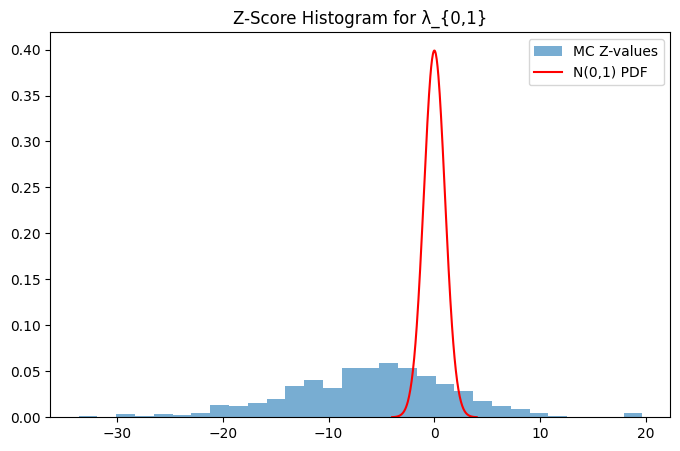

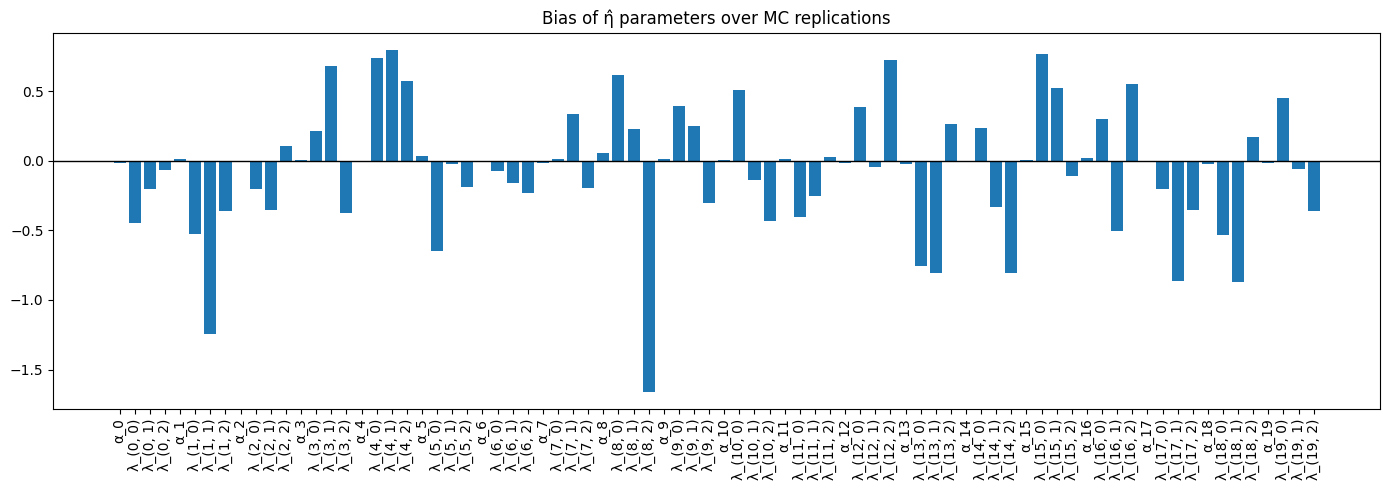

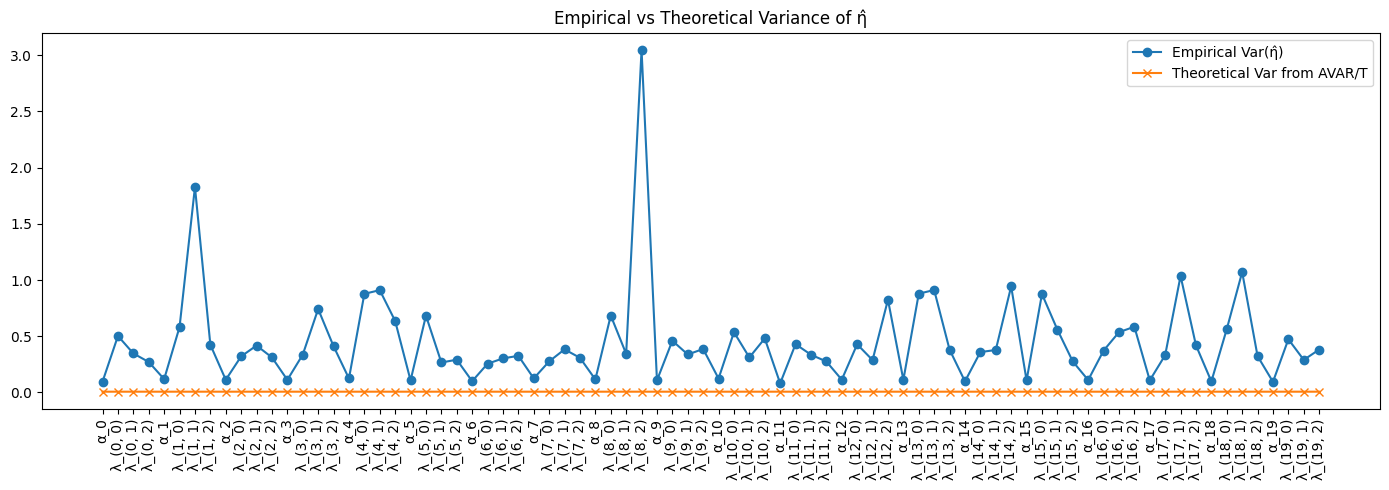

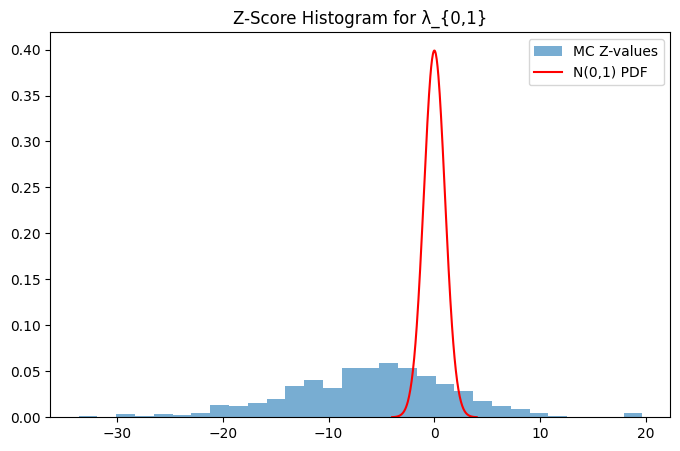

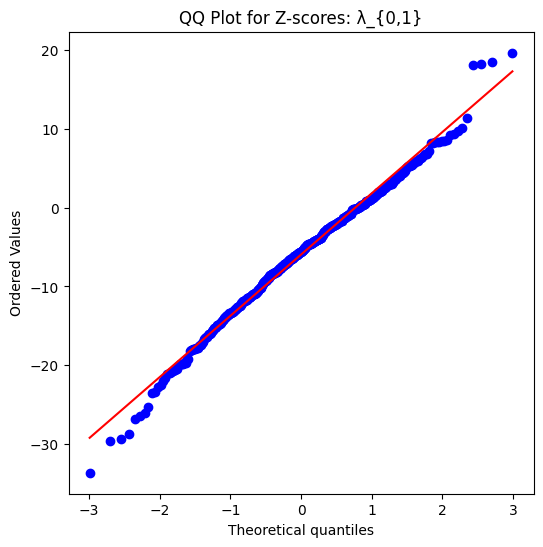

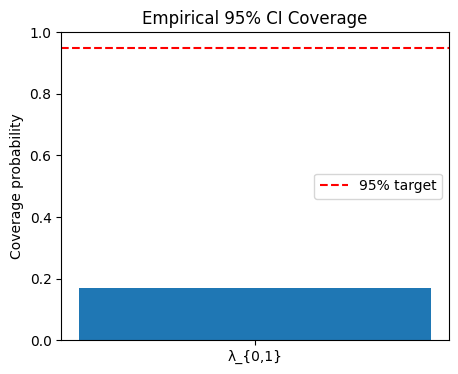

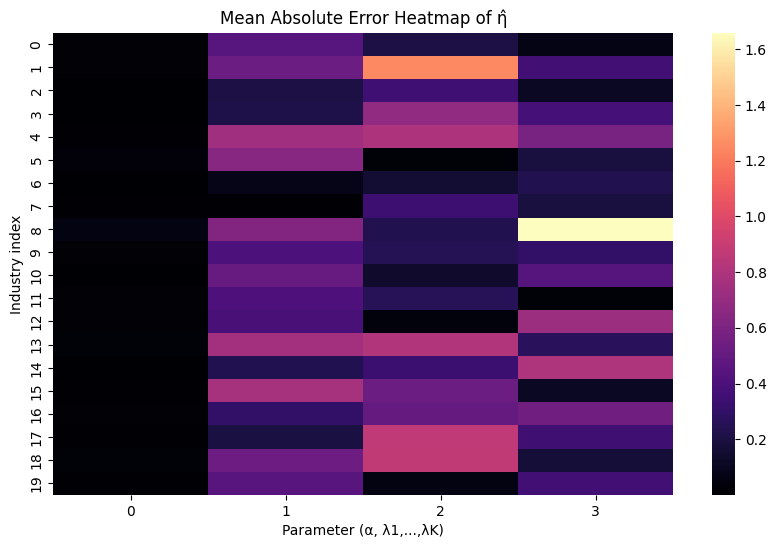

/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_22666/4028456446.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(eta_hats.reshape(eta_hats.shape[0], -1), labels=labels)


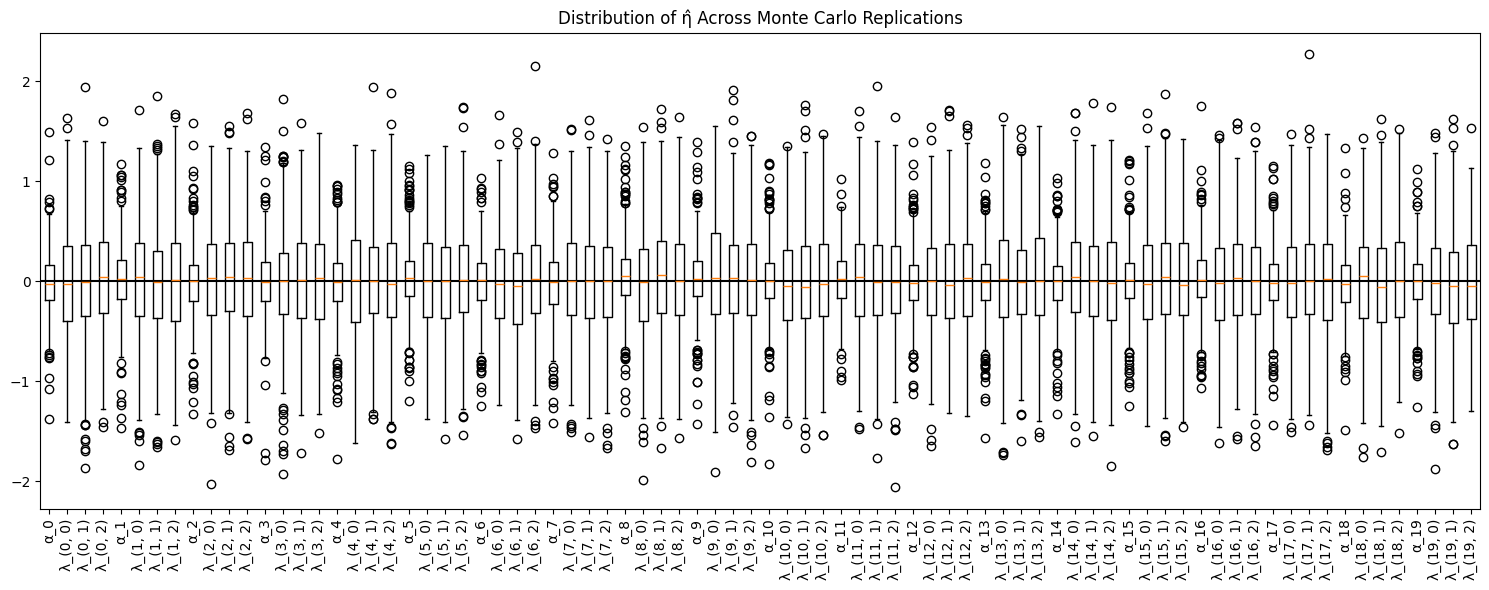

In [ ]:
param_label = "λ_{0,1}"   # Adjust depending on param_index
plot_z_histogram(z_vals, param_label)
plot_eta_bias(eta_hats, eta_true, N=20, K=3)
plot_variance_comparison(emp_cov, avars, T=200, N=20, K=3)
plot_z_histogram(z_vals, param_label)
plot_qq(z_vals, param_label)
plot_coverage(coverage, param_label)
plot_eta_heatmap(eta_hats, eta_true)
plot_eta_boxplots(eta_hats, eta_true, N=20, K=3)


==== NORMALITY CHECK ====
mean(z): -4.804067060910951
std(z): 7.551418289678208
KS test vs N(0,1): KstestResult(statistic=np.float64(0.6242362685243527), pvalue=np.float64(1.0800520439165965e-188), statistic_location=np.float64(-1.8842773985696188), statistic_sign=np.int8(1))

==== COVERAGE ====
Coverage probability: 0.184 (target = 0.95)


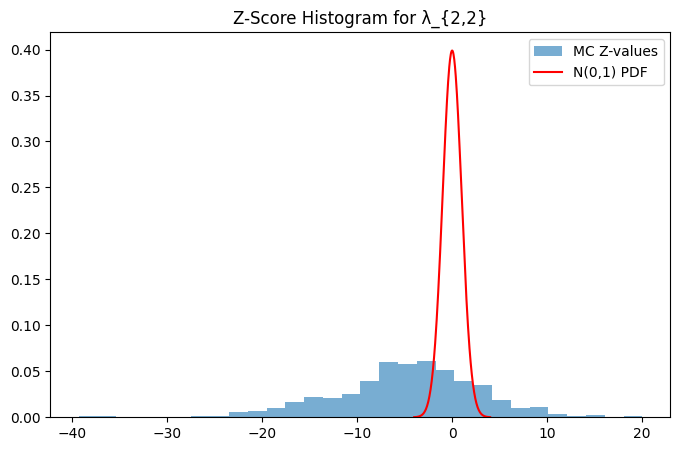

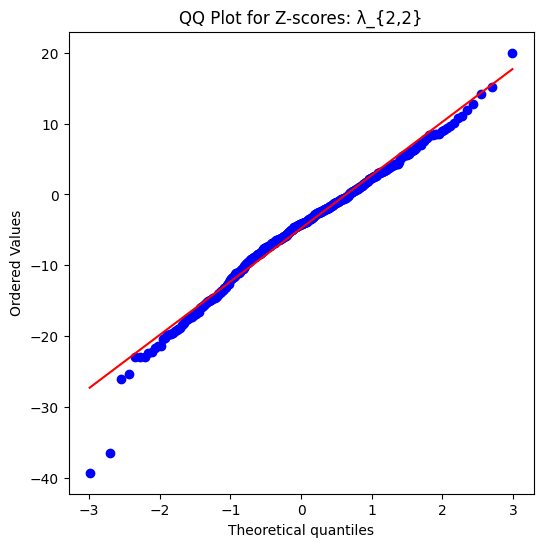

In [ ]:
# pick asset i and slope index j
i = 2    # asset 0
j = 2    # slope for factor 1 (assuming j=1..K)

def get_param_index(i, j, K):
    """
    i = industry index (0..N-1)
    j = 0 for intercept, 1..K for slopes
        j = 0 → intercept α_i
        j >= 1 → slope λ_{i,j-1}

    K = number of factors
    returns index in vec(eta)
    """
    Kp1 = K + 1
    return i * Kp1 + j

param_index = get_param_index(i, j, K=3)
param_label = f"λ_{{{i},{j}}}"

z_vals = check_z_normality(
    eta_hats, avars, eta_true_vec, T=200, param_index=param_index
)

coverage_probability(
    eta_hats, avars, eta_true_vec, param_index=param_index, T=200
)

plot_z_histogram(z_vals, param_label)
plot_qq(z_vals, param_label)

In [ ]:
def plot_all_z_histograms(eta_hats, avars, eta_true_vec, N, K, T, bins=20):
    """
    Creates a grid of z-score histograms:
    Shape: N rows × (K+1) columns.
    """

    p = N * (K+1)
    n_rep = eta_hats.shape[0]

    fig, axes = plt.subplots(N, K+1, figsize=(3*(K+1), 2.5*N), squeeze=False)

    for i in range(N):
        for j in range(K+1):
            ax = axes[i, j]

            param_index = get_param_index(i, j, K)

            # compute z-values for this parameter
            z_vals = []
            for rep in range(n_rep):
                eta_vec = eta_hats[rep].reshape(p)
                avar_hat = avars[rep]
                se = np.sqrt(avar_hat[param_index, param_index] / T)
                z = (eta_vec[param_index] - eta_true_vec[param_index]) / se
                z_vals.append(z)
            z_vals = np.array(z_vals)

            # histogram
            ax.hist(z_vals, bins=bins, density=True, alpha=0.6)

            # normal pdf
            x = np.linspace(-4,4,200)
            ax.plot(x, norm.pdf(x), "r--", linewidth=1)

            # label
            if j == 0:
                ax.set_title(f"α_{i}")
            else:
                ax.set_title(f"λ_{i},{j-1}")

    plt.tight_layout()
    plt.show()

def compute_z_matrix(eta_hats, avars, eta_true_vec, N, K, T):
    """
    Returns an N x (K+1) matrix of z-score deviation:
       deviation = |mean(z)| + |std(z) - 1|
    Larger numbers = worse normal fit.
    """
    p = N * (K+1)
    n_rep = eta_hats.shape[0]

    deviation = np.zeros((N, K+1))

    for i in range(N):
        for j in range(K+1):
            param_index = get_param_index(i, j, K)

            # compute z-values
            z_vals = []
            for rep in range(n_rep):
                eta_vec = eta_hats[rep].reshape(p)
                avar_hat = avars[rep]
                se = np.sqrt(avar_hat[param_index, param_index] / T)
                z = (eta_vec[param_index] - eta_true_vec[param_index]) / se
                z_vals.append(z)
            z_vals = np.array(z_vals)

            # deviation from N(0,1)
            deviation[i,j] = abs(z_vals.mean()) + abs(z_vals.std() - 1)

    return deviation

def plot_z_heatmap(eta_hats, avars, eta_true_vec, N, K, T):
    deviation = compute_z_matrix(eta_hats, avars, eta_true_vec, N, K, T)

    plt.figure(figsize=(10,6))
    sns.heatmap(
        deviation,
        cmap="viridis",
        xticklabels=[f"α"] + [f"λ_{j}" for j in range(K)],
        yticklabels=[f"i={i}" for i in range(N)],
        annot=True,
        fmt=".2f"
    )
    plt.title("Z-score Deviation Heatmap\n(|mean(z)| + |std(z)-1|)")
    plt.show()

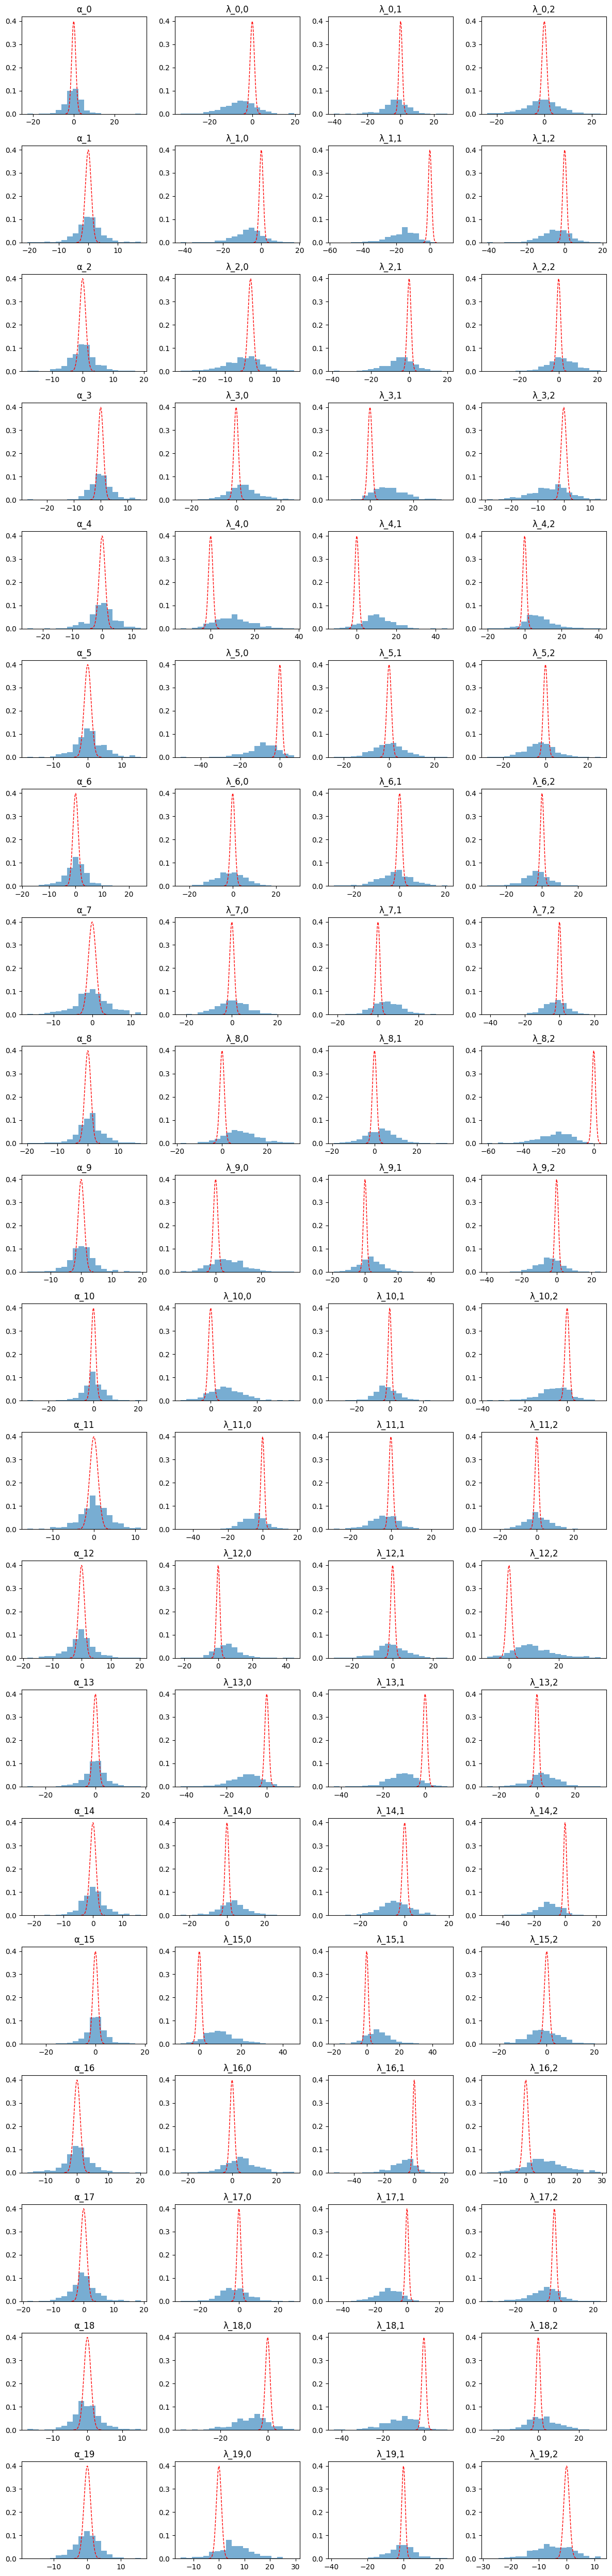

In [ ]:
plot_all_z_histograms(
    eta_hats, avars, eta_true_vec,
    N=20, K=3, T=200
)

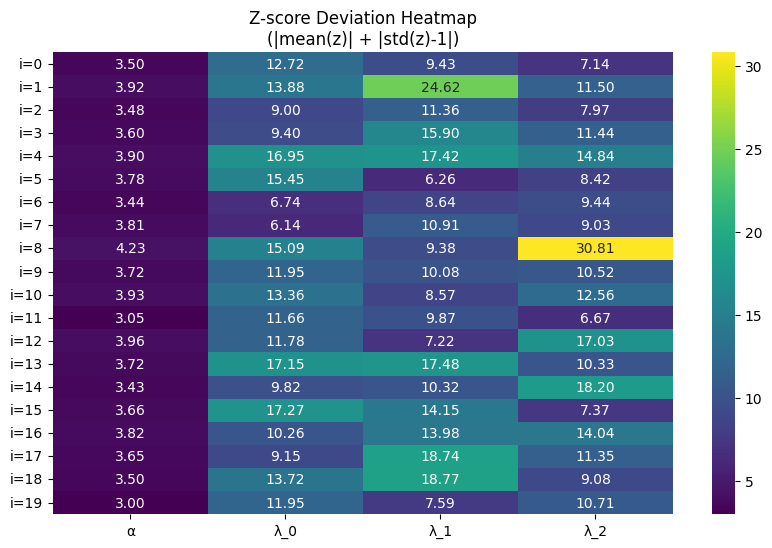

In [ ]:
plot_z_heatmap(
    eta_hats, avars, eta_true_vec,
    N=20, K=3, T=200,
)